In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
import torchvision.transforms as transforms
#from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import tqdm
import copy

from torch.utils.data import DataLoader, Dataset


In [2]:
# model
# Defining a time-dependent score-based model

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, x_dim , hidden_depth=2, embed_dim=128, use_bn=True):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        self.x_dim = x_dim
        self.hidden_depth = hidden_depth
        self.embed_dim = embed_dim
        self.use_bn = use_bn

        assert hidden_depth>=1, 'hidden_depth must be greater than 0!'
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))

        # fc layers
        self.input = nn.Linear(x_dim, embed_dim)
        self.fc_all = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for i in range(self.hidden_depth)])
        self.output = nn.Linear(embed_dim, x_dim)

        if self.use_bn:
            self.bn = nn.ModuleList([nn.BatchNorm1d(num_features=embed_dim) for i in range(self.hidden_depth)])

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std


    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))

        #
        h = self.input(x)
        # residue connections
        for i in range(self.hidden_depth):
            h = h + self.act(self.fc_all[i](h)) + embed
            if self.use_bn:
                h = self.bn[i](h)

        h = self.output(h)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None,]
        return h


# Define the loss function
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps #(eps,1)
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=1))
    return loss


def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The standard deviation.
    """
    # t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))


def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    # return torch.tensor(sigma**t, device=device)
    return sigma**t


# data set
class MyDataset(Dataset):
    def __init__(self, x_train):
        super().__init__()
        self.x_train = x_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return self.x_train[idx]



def train_model(score_model, x_sample, lr=1e-4, batch_size=1000, n_epochs=5000, print_interval=100):
    dataset = MyDataset(x_sample)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = Adam(score_model.parameters(), lr=lr)
    train_loss = []


    for epoch in range(n_epochs):
        avg_loss = 0.
        num_items = 0
        for x in data_loader:
            x = x.to(device)
            loss = loss_fn(score_model, x, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
        # Print the averaged training loss so far.
        epoch_avg_loss = avg_loss / num_items
        train_loss.append(epoch_avg_loss)
        if epoch%print_interval==0:
            print(f'epoch: {epoch}\t loss: {epoch_avg_loss}')
    return train_loss


def Euler_Maruyama_sampler(score_prior, marginal_prob_std, diffusion_coeff, score_likelihood=None,
                           batch_size=64,num_steps=500,device='cpu',eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
    the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
    Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, score_prior.x_dim, device=device) \
    * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            if score_likelihood is None:
                score = score_prior(x, batch_time_step)
            else:
                score = score_prior(x, batch_time_step) + score_likelihood(x)*torch.relu(1-2*time_step)

            # score = torch.clip(score, min=-100, max=100)

            score_norm = torch.sqrt(torch.mean(score**2, dim=1))
            adj_ratio = torch.ones_like(score_norm)
            tol = 50.
            adj_ratio[score_norm>tol] = tol/score_norm[score_norm>tol]
            # score_norm = torch.clip(score_norm, min=0, max=50)


            score = score*adj_ratio[:,None]

            # print(time_step, score)

            mean_x = x + (g**2)[:, None] * score * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)
        # Do not include any noise in the last sampling step.
    return mean_x


In [3]:
# diffusion setup
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

torch.manual_seed(123456987)
np.random.seed(12362186)

In [4]:
# define obs system
# h(x) = x^3



def likelihood_1d(x, obs, sigma_obs):
    return torch.exp(-0.5*(x**3 - obs)**2/sigma_obs**2)

def likelihood_score_1d(x, obs, sigma_obs):
    temp1 = -(x**3 - obs)/sigma_obs**2
    temp2 = 3*x**2
    return temp2*temp1


def likelihood(x, obs, sigma_obs):
    l1 = likelihood_1d(x[:,0], obs[0], sigma_obs)
    l2 = likelihood_1d(x[:,1], obs[1], sigma_obs)
    return l1*l2

def likelihood_score(x, obs, sigma_obs):
    score_d = []
    for d in range(num_dim):
        score_d.append(likelihood_score_1d(x[:,d], obs[d], sigma_obs))
        #score_d[d] = likelihood_score_1d(x[:,d], obs[0], sigma_obs)
    
    sc = torch.stack(score_d, dim=1)
    return sc

def likelihood_score_damp(x, obs, sigma_obs, c=0.01):
    sc1 = likelihood_score_1d(x[:,0], obs[0], sigma_obs)
    sc2 = likelihood_score_1d(x[:,1], obs[1], sigma_obs)
    sc = torch.stack([sc1, sc2], dim=1)
    sc_gauss = -(x)/c

    sc_norm = torch.mean(sc**2, dim=1)
    gauss_norm = torch.mean(sc_gauss**2, dim=1)
    sc[sc_norm > gauss_norm] = sc_gauss[sc_norm > gauss_norm]
    return sc

# filtering setup

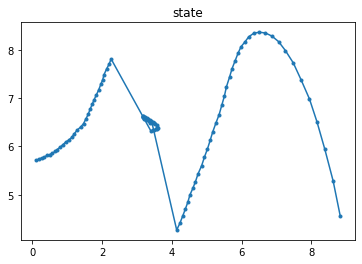

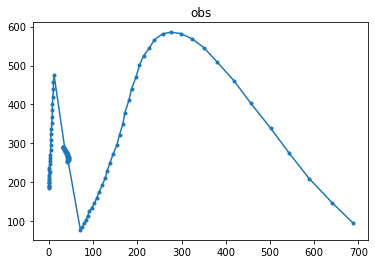

In [5]:
# Problem formulation
# state process setup
Time = 1.00
dt = 0.01
num_dim = 10
X_initial = torch.randn(num_dim)*2+4
N_T = int(Time//dt+1)
t_path = np.linspace(0, Time, N_T)
sigma_SDE = 0.1
F = 8


#dt = t_path[1] - t_path[0]


X_path = torch.zeros((N_T, num_dim))
X_path[0] = X_initial.clone()
x_new = X_initial.clone()

for i in range(N_T-1):
    # Generate true state trajectory
    x_old = X_path[i]
    
    x_new[0] = x_old[0] + ( (x_old[1] - x_old[num_dim-2])*x_old[num_dim-1] - x_old[0] + F)*dt + sigma_SDE*np.random.randn(1) * np.sqrt(dt)
    x_new[1] = x_old[1] + ( (x_old[2] - x_old[num_dim-1])*x_old[0] - x_old[1] + F)*dt + sigma_SDE*np.random.randn(1) * np.sqrt(dt)
    x_new[num_dim-1] = x_old[num_dim-1] + ( (x_old[0] - x_old[num_dim-3])*x_old[num_dim-2] - x_old[num_dim-1] + F)*dt + sigma_SDE*np.random.randn(1) * np.sqrt(dt)
    
    for d in range(2, num_dim-1):
        x_new[d] = x_old[d] + ( (x_old[d+1] - x_old[d-2])*x_old[d-1] - x_old[d] + F)*dt + sigma_SDE*np.random.randn(1) * np.sqrt(dt)
        #print(x_new[d])
        #print(d)
    #x_new[num_dim-1] = x_new[0]    

    X_path[i+1] = x_new
    
    if i==30:
        X_path[i+1] = X_path[i+1] + torch.randn(num_dim)*3
    if i==60:
        X_path[i+1] = X_path[i+1] + torch.randn(num_dim)*3

# get observation
sigma_obs = 0.5

obs_path_true = X_path**3
obs_path = obs_path_true + np.random.randn(N_T,num_dim)*sigma_obs

# plot
plt.plot(X_path[:,0],X_path[:,1],'.-',label='obs')
plt.title('state')
plt.show()

plt.plot(obs_path[:,0],obs_path[:,1],'.-',label='obs')
plt.title('obs')
plt.show()



In [6]:
# initial guess
x0 = torch.tensor(X_initial.clone(), dtype=torch.float32, device=device)
sigma0 = 0.5

print(X_initial)


tensor([0.1021, 5.7145, 4.3233, 0.9976, 4.3922, 2.7011, 3.5758, 4.0199, 5.6632,
        2.3283])


C:\Users\10576\AppData\Local\Temp\ipykernel_2444\2126229071.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(X_initial.clone(), dtype=torch.float32, device=device)


In [11]:
# Training initialize
x_dim = num_dim
hidden_depth  = 2
embed_dim = 200
use_bn = False

score_prior_old = ScoreNet(marginal_prob_std=marginal_prob_std_fn, x_dim=x_dim,
                           hidden_depth=hidden_depth, embed_dim=embed_dim, use_bn=use_bn)

score_prior_new = ScoreNet(marginal_prob_std=marginal_prob_std_fn, x_dim=x_dim,
                           hidden_depth=hidden_depth, embed_dim=embed_dim, use_bn=use_bn)

score_prior_old = score_prior_old.to(device)
score_prior_new = score_prior_new.to(device)

# initial samples
sample_size = 10000
x_init = x0 + torch.randn(sample_size,num_dim, dtype=torch.float32, device=device)*sigma0
train_loss = train_model(score_prior_old, x_sample=x_init, batch_size=10000, lr=0.01, n_epochs=1000, print_interval=100)

likelihood_score_fn = None
score_prior_new = score_prior_old

epoch: 0	 loss: 56.695579528808594
epoch: 100	 loss: 2.759016513824463
epoch: 200	 loss: 2.2534046173095703
epoch: 300	 loss: 2.089679002761841
epoch: 400	 loss: 2.128941297531128
epoch: 500	 loss: 2.019395351409912
epoch: 600	 loss: 2.084850549697876
epoch: 700	 loss: 2.013529062271118
epoch: 800	 loss: 2.0418601036071777
epoch: 900	 loss: 1.9938313961029053


In [12]:
est_all = []
x_prior = x_init.clone()
for i in range(N_T-1):
    print(i)
    
    score_prior_old = score_prior_new
    score_prior_new = copy.deepcopy(score_prior_new)
    
    # sample initial distribution
    x_init = Euler_Maruyama_sampler(score_prior_old,marginal_prob_std_fn, diffusion_coeff_fn,score_likelihood=likelihood_score_fn,
                                   batch_size=sample_size,num_steps=1000,device=device)
    est_all.append(torch.mean(x_init, dim=0).cpu().numpy())


    # solve for forward SDE (prediction)
    x_prior[:,0] = x_init[:,0] + ( (x_init[:,1] - x_init[:,num_dim-2])*x_init[:,num_dim-1] - x_init[:,0] + F)*dt + torch.randn(sample_size,device=device) * np.sqrt(dt)
    x_prior[:,1] = x_init[:,1] + ( (x_init[:,2] - x_init[:,num_dim-1])*x_init[:,0] - x_init[:,1] + F)*dt + torch.randn(sample_size,device=device) * np.sqrt(dt)
    x_prior[:,num_dim-1] = x_init[:,num_dim-1] + ( (x_init[:,0] - x_init[:,num_dim-3])*x_init[:,num_dim-2] - x_init[:,num_dim-1] + F)*dt + torch.randn(sample_size,device=device) * np.sqrt(dt)
    for d in range(1, num_dim-2):
        x_prior[:,d] = x_init[:,d] + ( (x_init[:,d+1] - x_init[:,d-2])*x_init[:,d-1] - x_init[:,d] + F)*dt + torch.randn(sample_size, device=device) * np.sqrt(dt)
      
    

    
    print('est: ',est_all[i])
    print('state: ',X_path[i])

    # train model for prior distribution
    train_loss = train_model(score_prior_new, x_sample=x_prior,
                             batch_size=10000,lr=0.001, n_epochs=500, print_interval=100)

    # new observation
    #obs_current = torch.from_numpy(obs_path[i+1,:]).float().to(device)
    obs_current = np.array(obs_path[i+1,:])

    # update likelihood function
    likelihood_score_fn = functools.partial(likelihood_score, obs=obs_current, sigma_obs=sigma_obs)
    # likelihood_score_fn = functools.partial(likelihood_score_damp, obs=obs_current, sigma_obs=sigma_obs, c=0.1)
    # next iteration

# last estimation
# sample initial distribution
x_init = Euler_Maruyama_sampler(score_prior_old,marginal_prob_std_fn, diffusion_coeff_fn,score_likelihood=likelihood_score_fn,
                               batch_size=sample_size,num_steps=500,device=device)
est_all.append(torch.mean(x_init, dim=0).cpu().numpy())

est_all = np.array(est_all)


0


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [0.1689965  5.6499577  4.276519   0.98624665 4.38035    2.6676824
 3.5080268  3.9815812  5.61131    2.2725945 ]
state:  tensor([0.1021, 5.7145, 4.3233, 0.9976, 4.3922, 2.7011, 3.5758, 4.0199, 5.6632,
        2.3283])
epoch: 0	 loss: 2.14328670501709
epoch: 100	 loss: 2.0670278072357178
epoch: 200	 loss: 2.0581424236297607
epoch: 300	 loss: 2.0262746810913086
epoch: 400	 loss: 1.9972312450408936
1


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [0.05878197 5.734577   4.402752   0.2759857  4.401356   2.7595487
 3.6130464  4.1733103  5.6298976  1.8796941 ]
state:  tensor([0.1827, 5.7333, 4.4057, 1.0167, 4.4007, 2.8507, 3.6180, 4.1855, 5.6252,
        2.1585])
epoch: 0	 loss: 2.15840220451355
epoch: 100	 loss: 1.5823007822036743
epoch: 200	 loss: 1.4379159212112427
epoch: 300	 loss: 1.2769192457199097
epoch: 400	 loss: 1.2935349941253662
2


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [-0.02633368  5.753712    4.4920807   0.23359814  4.439829    2.9744709
  3.6871898   4.3113704   5.592037    1.5810633 ]
state:  tensor([0.2678, 5.7607, 4.4828, 1.0343, 4.4303, 3.0213, 3.6764, 4.3112, 5.5939,
        1.9947])
epoch: 0	 loss: 1.4175207614898682
epoch: 100	 loss: 1.3091892004013062
epoch: 200	 loss: 1.2864980697631836
epoch: 300	 loss: 1.2915937900543213
epoch: 400	 loss: 1.2815628051757812
3


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [0.06734042 5.7649374  4.5595837  0.08853766 4.4620676  3.1505327
 3.7348936  4.463971   5.5478606  1.115582  ]
state:  tensor([0.3495, 5.7720, 4.5589, 1.0454, 4.4540, 3.1937, 3.7375, 4.4549, 5.5416,
        1.8249])
epoch: 0	 loss: 1.5070050954818726
epoch: 100	 loss: 1.302839994430542
epoch: 200	 loss: 1.2543270587921143
epoch: 300	 loss: 1.3179283142089844
epoch: 400	 loss: 1.330349326133728
4


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [-0.07447752  5.817565    4.6243677   0.11913662  4.4825406   3.347935
  3.7797604   4.5593896   5.4746537   0.75285274]
state:  tensor([0.4169, 5.8136, 4.6246, 1.0497, 4.4858, 3.3591, 3.7762, 4.5670, 5.4662,
        1.6713])
epoch: 0	 loss: 1.4712555408477783
epoch: 100	 loss: 1.3454854488372803
epoch: 200	 loss: 1.3359304666519165
epoch: 300	 loss: 1.3324565887451172
epoch: 400	 loss: 1.3591325283050537
5


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [-0.11026477  5.826297    4.691868    0.14986685  4.503625    3.5307643
  3.8047175   4.6761117   5.3737183   0.5366161 ]
state:  tensor([0.4958, 5.8316, 4.6903, 1.0736, 4.4946, 3.5462, 3.8293, 4.6847, 5.3754,
        1.5169])
epoch: 0	 loss: 1.3996998071670532
epoch: 100	 loss: 1.3508884906768799
epoch: 200	 loss: 1.3088074922561646
epoch: 300	 loss: 1.3227064609527588
epoch: 400	 loss: 1.3053470849990845
6


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [-0.03022818  5.856177    4.7620187   0.26427177  4.5279183   3.6983373
  3.8746164   4.7919655   5.295439    0.2676065 ]
state:  tensor([0.5798, 5.8581, 4.7618, 1.0899, 4.5273, 3.7062, 3.8858, 4.7919, 5.3020,
        1.3598])
epoch: 0	 loss: 1.4149383306503296
epoch: 100	 loss: 1.3249468803405762
epoch: 200	 loss: 1.3331704139709473
epoch: 300	 loss: 1.3184341192245483
epoch: 400	 loss: 1.3187423944473267
7


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [0.06314489 5.896517   4.843042   0.22843337 4.556068   3.8769398
 3.9304726  4.9017115  5.2123184  0.23705041]
state:  tensor([0.6647, 5.8973, 4.8332, 1.0968, 4.5559, 3.8831, 3.9458, 4.8947, 5.2175,
        1.2218])
epoch: 0	 loss: 1.4337220191955566
epoch: 100	 loss: 1.3370766639709473
epoch: 200	 loss: 1.3126901388168335
epoch: 300	 loss: 1.3053686618804932
epoch: 400	 loss: 1.2814792394638062
8


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [0.04339335 5.928191   4.884989   0.21415542 4.573316   4.0470204
 3.9836655  4.978292   5.1256375  0.20734555]
state:  tensor([0.7171, 5.9352, 4.8855, 1.1072, 4.5667, 4.0526, 3.9971, 4.9747, 5.1253,
        1.0592])
epoch: 0	 loss: 1.3599025011062622
epoch: 100	 loss: 1.272608995437622
epoch: 200	 loss: 1.3063207864761353
epoch: 300	 loss: 1.2970435619354248
epoch: 400	 loss: 1.3037259578704834
9


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [-0.08115793  5.971719    4.9420857   0.27721915  4.6063247   4.197666
  4.0473595   5.0498896   5.0024047  -0.05821189]
state:  tensor([0.7881, 5.9773, 4.9366, 1.1098, 4.5951, 4.2141, 4.0635, 5.0516, 5.0047,
        0.9096])
epoch: 0	 loss: 1.4016770124435425
epoch: 100	 loss: 1.3394927978515625
epoch: 200	 loss: 1.3271912336349487
epoch: 300	 loss: 1.283223032951355
epoch: 400	 loss: 1.3614013195037842
10


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [0.0105111  6.032279   4.988302   0.19545175 4.617726   4.399563
 4.12106    5.113038   4.880992   0.03623971]
state:  tensor([0.8704, 6.0297, 4.9887, 1.1121, 4.6299, 4.3925, 4.1185, 5.1092, 4.8663,
        0.7605])
epoch: 0	 loss: 1.438934326171875
epoch: 100	 loss: 1.3066835403442383
epoch: 200	 loss: 1.3022722005844116
epoch: 300	 loss: 1.291326880455017
epoch: 400	 loss: 1.317706823348999
11


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 0.16449419  6.0916853   5.033251    0.18164496  4.6418657   4.571
  4.2133703   5.110715    4.7267723  -0.00709009]
state:  tensor([0.9569, 6.0879, 5.0258, 1.1135, 4.6610, 4.5664, 4.2108, 5.1234, 4.7253,
        0.6311])
epoch: 0	 loss: 1.4279698133468628
epoch: 100	 loss: 1.3146642446517944
epoch: 200	 loss: 1.3357821702957153
epoch: 300	 loss: 1.2939116954803467
epoch: 400	 loss: 1.3519057035446167
12


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 0.11918581  6.129886    5.071803    0.14767903  4.683778    4.733628
  4.295728    5.171551    4.5720763  -0.03285943]
state:  tensor([1.0519, 6.1342, 5.0708, 1.1092, 4.6926, 4.7433, 4.2833, 5.1747, 4.5853,
        0.5073])
epoch: 0	 loss: 1.3958125114440918
epoch: 100	 loss: 1.3134156465530396
epoch: 200	 loss: 1.3375589847564697
epoch: 300	 loss: 1.2982385158538818
epoch: 400	 loss: 1.3251864910125732
13


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 0.1422279   6.184793    5.082839    0.23835842  4.7308793   4.920378
  4.350067    5.1999884   4.422699   -0.10517314]
state:  tensor([1.1313, 6.1854, 5.0904, 1.0982, 4.7310, 4.9295, 4.3566, 5.1939, 4.4282,
        0.3820])
epoch: 0	 loss: 1.4479490518569946
epoch: 100	 loss: 1.309186339378357
epoch: 200	 loss: 1.351646900177002
epoch: 300	 loss: 1.2935131788253784
epoch: 400	 loss: 1.3235951662063599
14


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [0.24990162 6.267919   5.116687   0.1052938  4.7936044  5.104133
 4.3986654  5.200712   4.2802615  0.07738911]
state:  tensor([1.2081, 6.2644, 5.1212, 1.0842, 4.7745, 5.1093, 4.4065, 5.2018, 4.2902,
        0.2632])
epoch: 0	 loss: 1.4437084197998047
epoch: 100	 loss: 1.3301401138305664
epoch: 200	 loss: 1.3303589820861816
epoch: 300	 loss: 1.341812014579773
epoch: 400	 loss: 1.3491626977920532
15


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 0.22007275  6.331321    5.176489    0.19483605  4.822615    5.301884
  4.4492717   5.2057867   4.1328607  -0.01826249]
state:  tensor([1.2856, 6.3357, 5.1664, 1.0739, 4.8198, 5.3018, 4.4528, 5.2013, 4.1261,
        0.1690])
epoch: 0	 loss: 1.4071460962295532
epoch: 100	 loss: 1.3811073303222656
epoch: 200	 loss: 1.3222768306732178
epoch: 300	 loss: 1.3242548704147339
epoch: 400	 loss: 1.3706544637680054
16


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 0.29876882  6.4027653   5.1707873   0.12275908  4.851557    5.472882
  4.4588094   5.1799703   3.9467793  -0.08930343]
state:  tensor([1.3940, 6.4057, 5.1689, 1.0337, 4.8480, 5.4813, 4.4859, 5.1880, 3.9367,
        0.0976])
epoch: 0	 loss: 1.384759545326233
epoch: 100	 loss: 1.308007836341858
epoch: 200	 loss: 1.3176202774047852
epoch: 300	 loss: 1.3470630645751953
epoch: 400	 loss: 1.3362867832183838
17


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [4.4186625e-01 6.4686527e+00 5.1814704e+00 1.5129077e-01 4.8955407e+00
 5.6828442e+00 4.5147600e+00 5.1590724e+00 3.7524726e+00 2.7740025e-03]
state:  tensor([1.4697, 6.4716, 5.1839, 1.0178, 4.8885, 5.6807, 4.5367, 5.1527, 3.7543,
        0.0236])
epoch: 0	 loss: 1.5000749826431274
epoch: 100	 loss: 1.3287625312805176
epoch: 200	 loss: 1.3782185316085815
epoch: 300	 loss: 1.3378328084945679
epoch: 400	 loss: 1.345950722694397
18


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [0.51228267 6.572808   5.168543   0.08280138 4.9017053  5.868164
 4.5827446  5.098135   3.5644133  0.06294447]
state:  tensor([ 1.5430,  6.5761,  5.1811,  1.0230,  4.9086,  5.8707,  4.5790,  5.1005,
         3.5656, -0.0361])
epoch: 0	 loss: 1.4484269618988037
epoch: 100	 loss: 1.3868166208267212
epoch: 200	 loss: 1.3518351316452026
epoch: 300	 loss: 1.3786944150924683
epoch: 400	 loss: 1.365873098373413
19


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 0.5312919   6.6615124   5.184042    0.05968609  4.9285216   6.0448985
  4.60297     5.0300913   3.3524406  -0.01162045]
state:  tensor([ 1.6065,  6.6682,  5.1914,  0.9986,  4.9428,  6.0463,  4.6153,  5.0252,
         3.3579, -0.0817])
epoch: 0	 loss: 1.464680552482605
epoch: 100	 loss: 1.3584178686141968
epoch: 200	 loss: 1.3803101778030396
epoch: 300	 loss: 1.3859983682632446
epoch: 400	 loss: 1.3392949104309082
20


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [0.4875125  6.766831   5.1599903  0.11399243 4.978849   6.2372336
 4.6155014  4.906883   3.1744819  0.0167013 ]
state:  tensor([ 1.6547,  6.7643,  5.1720,  0.9662,  4.9783,  6.2326,  4.6301,  4.9145,
         3.1782, -0.1248])
epoch: 0	 loss: 1.5087823867797852
epoch: 100	 loss: 1.3353495597839355
epoch: 200	 loss: 1.3467143774032593
epoch: 300	 loss: 1.394924521446228
epoch: 400	 loss: 1.3636668920516968
21


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 0.54249984  6.8706827   5.143353    0.06617672  4.995304    6.417495
  4.650522    4.791054    2.996453   -0.07224561]
state:  tensor([ 1.7171,  6.8684,  5.1570,  0.9374,  5.0061,  6.4225,  4.6594,  4.8014,
         2.9851, -0.1446])
epoch: 0	 loss: 1.5091911554336548
epoch: 100	 loss: 1.3812062740325928
epoch: 200	 loss: 1.3871225118637085
epoch: 300	 loss: 1.346397876739502
epoch: 400	 loss: 1.379450798034668
22


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 0.6426901   6.9609623   5.130021    0.07815222  5.048018    6.6223826
  4.6502485   4.6684203   2.7999215  -0.04016817]
state:  tensor([ 1.7703,  6.9633,  5.1411,  0.9042,  5.0436,  6.6269,  4.6524,  4.6773,
         2.8152, -0.1566])
epoch: 0	 loss: 1.469494342803955
epoch: 100	 loss: 1.417820692062378
epoch: 200	 loss: 1.3495291471481323
epoch: 300	 loss: 1.367072343826294
epoch: 400	 loss: 1.3533717393875122
23


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [0.75049293 7.0622764  5.100613   0.07404733 5.0821576  6.840378
 4.6451015  4.5416875  2.5874577  0.03923543]
state:  tensor([ 1.8384,  7.0666,  5.1001,  0.8733,  5.0946,  6.8396,  4.6637,  4.5481,
         2.6281, -0.1655])
epoch: 0	 loss: 1.552566409111023
epoch: 100	 loss: 1.4110740423202515
epoch: 200	 loss: 1.360439658164978
epoch: 300	 loss: 1.371145486831665
epoch: 400	 loss: 1.3986862897872925
24


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 8.4396249e-01  7.1682577e+00  5.0327430e+00  6.7104600e-02
  5.1312294e+00  7.0541105e+00  4.6556940e+00  4.3508086e+00
  2.2958212e+00 -3.8047347e-03]
state:  tensor([ 1.9028,  7.1682,  5.0442,  0.8461,  5.1265,  7.0506,  4.6749,  4.3758,
         2.4690, -0.1418])
epoch: 0	 loss: 1.5844956636428833
epoch: 100	 loss: 1.408453106880188
epoch: 200	 loss: 1.4015414714813232
epoch: 300	 loss: 1.3762551546096802
epoch: 400	 loss: 1.3475925922393799
25


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 8.5637456e-01  7.2823358e+00  5.0170093e+00  8.6957745e-02
  5.1659317e+00  7.2464719e+00  4.6680794e+00  4.1496711e+00
  2.0494094e+00 -2.3568745e-03]
state:  tensor([ 1.9632,  7.2814,  5.0196,  0.8251,  5.1876,  7.2434,  4.6852,  4.1882,
         2.3049, -0.1192])
epoch: 0	 loss: 1.547195553779602
epoch: 100	 loss: 1.4406977891921997
epoch: 200	 loss: 1.466158151626587
epoch: 300	 loss: 1.3813706636428833
epoch: 400	 loss: 1.4012558460235596
26


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [8.8060719e-01 7.3763289e+00 4.9734998e+00 5.4673009e-02 5.2304325e+00
 7.4371700e+00 4.6299739e+00 3.9180388e+00 1.8049262e+00 7.1644727e-03]
state:  tensor([ 2.0188,  7.3787,  4.9768,  0.7967,  5.2406,  7.4392,  4.6450,  3.9898,
         2.1727, -0.0826])
epoch: 0	 loss: 1.659021019935608
epoch: 100	 loss: 1.4185335636138916
epoch: 200	 loss: 1.4139995574951172
epoch: 300	 loss: 1.3953306674957275
epoch: 400	 loss: 1.4409629106521606
27


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [0.9236494  7.4869637  4.888487   0.04646697 5.2846     7.658486
 4.580279   3.6619687  1.6366246  0.10472258]
state:  tensor([ 2.0580,  7.4872,  4.9015,  0.7462,  5.2857,  7.6609,  4.5931,  3.7744,
         2.0490, -0.0319])
epoch: 0	 loss: 1.7048070430755615
epoch: 100	 loss: 1.453487515449524
epoch: 200	 loss: 1.4145138263702393
epoch: 300	 loss: 1.4731062650680542
epoch: 400	 loss: 1.4688503742218018
28


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [1.0571384  7.597725   4.817679   0.0702087  5.336944   7.875836
 4.497893   3.4129913  1.4483922  0.05203645]
state:  tensor([2.1285, 7.5987, 4.8347, 0.7047, 5.3452, 7.8754, 4.5237, 3.5505, 1.9235,
        0.0107])
epoch: 0	 loss: 1.7275999784469604
epoch: 100	 loss: 1.5114967823028564
epoch: 200	 loss: 1.5075640678405762
epoch: 300	 loss: 1.518148422241211
epoch: 400	 loss: 1.4777538776397705
29


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [1.0139054  7.7007184  4.7509933  0.04453924 5.3819895  8.081643
 4.382613   3.1020741  1.1980338  0.02628838]
state:  tensor([2.2008, 7.7014, 4.7631, 0.6856, 5.3922, 8.0816, 4.4232, 3.3361, 1.8100,
        0.0653])
epoch: 0	 loss: 1.7580134868621826
epoch: 100	 loss: 1.5290907621383667
epoch: 200	 loss: 1.5493156909942627
epoch: 300	 loss: 1.5394632816314697
epoch: 400	 loss: 1.5287907123565674
30


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [1.0999000e+00 7.8086329e+00 4.6480327e+00 9.6764574e-03 5.4291544e+00
 8.2889519e+00 4.2442298e+00 2.7026751e+00 1.1878867e+00 7.2561749e-03]
state:  tensor([2.2615, 7.8083, 4.6681, 0.6541, 5.4460, 8.2865, 4.3022, 3.0839, 1.7276,
        0.1479])
epoch: 0	 loss: 1.8728374242782593
epoch: 100	 loss: 1.6506682634353638
epoch: 200	 loss: 1.598610281944275
epoch: 300	 loss: 1.5818949937820435
epoch: 400	 loss: 1.618947982788086
31


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 2.2567515   6.327842    0.6140081   0.03959077  1.6861546  10.138395
  3.705871    7.2291913   6.656775   -0.23283689]
state:  tensor([ 3.3940,  6.3268, -1.9354,  1.1149,  2.2563, 10.1381,  3.8794,  7.3448,
         6.6650, -1.7443])
epoch: 0	 loss: 26.629175186157227
epoch: 100	 loss: 2.372990846633911
epoch: 200	 loss: 2.206552028656006
epoch: 300	 loss: 2.1447947025299072
epoch: 400	 loss: 2.1399779319763184
32


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 2.6679585   6.327235   -0.15335476  0.19748704  1.3412187  10.175506
  4.2948556   7.215818    6.259434   -0.47373503]
state:  tensor([ 3.4632,  6.3308, -1.9788,  1.2665,  2.4655, 10.1762,  4.4146,  7.2189,
         6.2682, -1.9109])
epoch: 0	 loss: 2.8173341751098633
epoch: 100	 loss: 2.2318646907806396
epoch: 200	 loss: 2.210150957107544
epoch: 300	 loss: 2.175551414489746
epoch: 400	 loss: 2.2103431224823
33


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 2.8501866   6.335951   -0.4448885   0.22105214  1.3701713  10.212471
  4.8701863   7.064631    5.8248806  -0.5767623 ]
state:  tensor([ 3.5028,  6.3383, -2.0155,  1.4316,  2.6693, 10.2117,  4.9380,  7.0641,
         5.8364, -2.0459])
epoch: 0	 loss: 2.6790242195129395
epoch: 100	 loss: 2.159122943878174
epoch: 200	 loss: 2.1469063758850098
epoch: 300	 loss: 2.1571128368377686
epoch: 400	 loss: 2.0823535919189453
34


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 2.98533     6.3534465  -0.50315875  0.3144038   1.7312773  10.274873
  5.3918266   6.852328    5.349999   -0.6650704 ]
state:  tensor([ 3.5364,  6.3545, -2.0517,  1.5804,  2.9047, 10.2766,  5.4218,  6.8607,
         5.3661, -2.1489])
epoch: 0	 loss: 2.6377124786376953
epoch: 100	 loss: 2.0562901496887207
epoch: 200	 loss: 2.052263021469116
epoch: 300	 loss: 2.0356838703155518
epoch: 400	 loss: 2.0461924076080322
35


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 3.0872014   6.3581724  -0.5776661   0.34634158  2.150316   10.3715
  5.833356    6.6143374   4.8476048  -0.7250047 ]
state:  tensor([ 3.5699,  6.3656, -2.0652,  1.7050,  3.1484, 10.3717,  5.8452,  6.6211,
         4.8787, -2.2238])
epoch: 0	 loss: 2.4580349922180176
epoch: 100	 loss: 1.9561747312545776
epoch: 200	 loss: 1.9807958602905273
epoch: 300	 loss: 1.9877973794937134
epoch: 400	 loss: 2.014603853225708
36


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 3.1125512  6.380435  -0.6267923  0.3425982  2.6051452 10.482995
  6.233238   6.3241043  4.341771  -0.7499111]
state:  tensor([ 3.5910,  6.3727, -2.0809,  1.8441,  3.4195, 10.4833,  6.2333,  6.3238,
         4.3777, -2.2657])
epoch: 0	 loss: 2.4752464294433594
epoch: 100	 loss: 1.9467556476593018
epoch: 200	 loss: 1.9752528667449951
epoch: 300	 loss: 1.9889321327209473
epoch: 400	 loss: 1.9313913583755493
37


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 3.086923    6.3901806  -0.6063238   0.41954774  3.140168   10.623183
  6.5499625   5.9676785   3.8180547  -0.77073866]
state:  tensor([ 3.5832,  6.3990, -2.0884,  1.9631,  3.6829, 10.6220,  6.5494,  5.9679,
         3.8729, -2.2870])
epoch: 0	 loss: 2.466400384902954
epoch: 100	 loss: 1.8977785110473633
epoch: 200	 loss: 1.9246151447296143
epoch: 300	 loss: 1.8725624084472656
epoch: 400	 loss: 1.8903487920761108
38


  0%|          | 0/1000 [00:00<?, ?it/s]

est:  [ 3.0851278   6.423134   -0.6256126   0.49279588  3.536407   10.764795
  6.7901435   5.531466    3.2983937  -0.7303921 ]
state:  tensor([ 3.5759,  6.4325, -2.1039,  2.0756,  3.9853, 10.7635,  6.7939,  5.5518,
         3.3873, -2.2802])
epoch: 0	 loss: 2.4541311264038086


KeyboardInterrupt: 

In [ ]:
for i in range(x_dim):
    plt.plot(X_path[:,i], '.-', label='state')
    plt.plot(est_all[:,i], '.-', label='estimation')
    plt.legend()
    plt.title(f'dim {i}')
    plt.show()

In [ ]:
np.savetxt('Est_all_10d.txt', est_all)
np.savetxt('X_path_10d.txt', X_path)
np.savetxt('obs_path_10d.txt', obs_path)